In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 加载数据
df = pd.DataFrame(pd.read_csv("../Data/watermelon3.0.csv", encoding="ansi"))
df.drop(labels=["编号"], axis=1, inplace=True)  # 删除编号这一列，inplace=True表示直接在原对象修改
features = ['色泽', '根蒂', '敲声', '纹理', '脐部', '触感', '密度', '含糖量']
# 提取特征和标签
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
# 转码
X = pd.DataFrame(X, columns=features)
# 独热编码
X_encoded = pd.get_dummies(X,columns = ["色泽","根蒂","敲声","纹理","脐部","触感"])
new_features = list(X_encoded.columns)
X_encoded = np.array(X_encoded, dtype=np.float64)
# 标签数值化
for i in range(len(y)):
    if y[i] == '是':
        y[i] = 1
    else:
        y[i] = 0
y_encoded = np.array(y, dtype=np.int64).reshape(-1,1) # 转为列向量
# 拼接特征和标签
dataset = np.concatenate((X_encoded, y_encoded), axis=1)
print(dataset.shape)   

(17, 20)


In [37]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# 加载数据集
iris = load_iris()
X = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

y_train = pd.get_dummies(y_train).values
y_train = np.array(y_train, dtype=int)

Epoch: 10000 
Loss: 1.3950050574064528


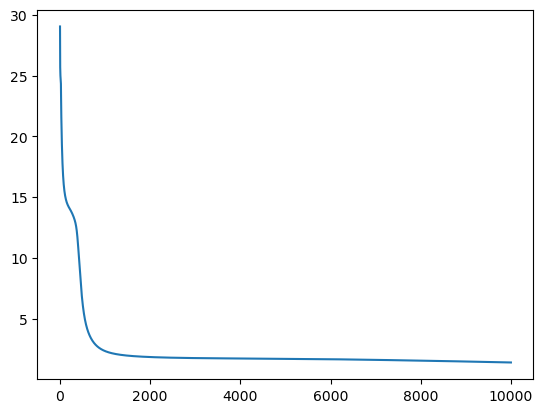

Epoch: 10000 
Loss: 1.714014620258125


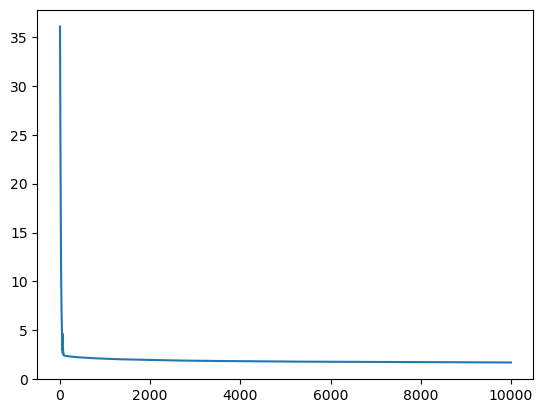

In [47]:
class Net_BP():
    def __init__(self, input_size = 19, hidden_size = 10, output_size = 1, lr = 0.1):
        """
        BP神经网络
        
        参数:
        input_size: 输入层大小
        hidden_size: 隐含层大小
        output_size: 输出层大小
        method: 训练方法，'standard_BP'表示标准BP算法，'accumulate_BP'表示累积BP算法
        lr: 学习率
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        # 输入与隐含层之间的连接权和阈值
        self.w1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.random.randn(1, hidden_size)
        # 隐含层与输出层之间的连接权和阈值
        self.w2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.random.randn(1, output_size)


    def sigmoid(self,z):
        """激活函数"""
        return 1.0 / (1.0 + np.exp(-z))
    
    def standard_BP(self,X,y):
        """标准BP算法"""
        loss = 1
        all_loss = []
        epoch = 0
        while epoch < 10000 and loss > 0.001:
            for i in range(X.shape[0]):
                # 前向传播
                b = self.sigmoid(X[i] @ self.w1 - self.b1) # 隐含层输出(1 × hidden_size)
                y_pred = self.sigmoid(b @ self.w2 - self.b2) # 输出层输出(1 × output_size)
                # 反向传播
                # 公式(5,10)
                g = y_pred * (1 - y_pred) * (y[i] - y_pred) # (1 × output_size)
                # 公式(5,15)
                e = b * (1 - b) * (g @ self.w2.T) # (1 × hidden_size)
                # 更新参数
                self.w2 += self.lr * (b.T @ g) # (hidden_size × output_size)
                self.b2 -= self.lr * g # (1 × output_size)
                self.w1 += self.lr * (X[i].reshape(-1,1) @ e) # (input_size × hidden_size)
                self.b1 -= self.lr * e # (1 × hidden_size)
            # 计算损失
            loss = self.calulate_loss(X,y)
            all_loss.append(loss)
            epoch += 1
        print('Epoch:', epoch,'\nLoss:', loss)
        # 绘制损失变化图
        plt.plot(all_loss)
        plt.show()

    def standard_BP_Plus(self,X,y):
        """优化标准BP算法"""
        loss = 1
        last_loss = 0
        all_loss = []
        epoch = 0
        start_lr = 0.1 / np.sqrt(self.hidden_size)
        lr_dynamic = start_lr
        while epoch < 10000 and loss > 0.001:
            for i in range(X.shape[0]):
                # 前向传播
                b = self.sigmoid(X[i] @ self.w1 - self.b1) # 隐含层输出(1 × hidden_size)
                y_pred = self.sigmoid(b @ self.w2 - self.b2) # 输出层输出(1 × output_size)
                # 反向传播
                # 公式(5,10)
                g = y_pred * (1 - y_pred) * (y[i] - y_pred) # (1 × output_size)
                # 公式(5,15)
                e = b * (1 - b) * (g @ self.w2.T) # (1 × hidden_size)
                # 更新参数
                self.w2 += lr_dynamic * (b.T @ g) # (hidden_size × output_size)
                self.b2 -= lr_dynamic * g # (1 × output_size)
                self.w1 += lr_dynamic * (X[i].reshape(-1,1) @ e) # (input_size × hidden_size)
                self.b1 -= lr_dynamic * e # (1 × hidden_size)
            # 计算损失
            last_loss = loss
            loss = self.calulate_loss(X,y)
            all_loss.append(loss)
            # 更新轮数
            epoch += 1
            # 动态更新学习率
            if last_loss < loss:
                lr_dynamic = max(lr_dynamic * 0.7, 0.001)
            else:
                lr_dynamic = min(lr_dynamic * 1.05, 0.5)
        print('Epoch:', epoch,'\nLoss:', loss)
        # 绘制损失变化图
        plt.plot(all_loss)
        plt.show()


    def predict(self,X):
        """预测"""
        b = self.sigmoid(X @ self.w1 - self.b1) # 隐含层输出(1 × hidden_size)
        y_pred = self.sigmoid(b @ self.w2 - self.b2) # 输出层输出(1 × output_size)
        return y_pred
    
    def calulate_loss(self,X,y):
        """计算损失"""
        loss = 0
        loss = (1/2) * np.sum((y - self.predict(X))**2)
        return loss
    
    

if __name__ == '__main__':
    BP_Std = Net_BP(input_size=4, hidden_size=5, output_size=3, lr=0.02)
    BP_Std.standard_BP(x_train,y_train)

    BP_Std_Plus = Net_BP(input_size=4, hidden_size=5, output_size=3, lr=0.1)
    BP_Std_Plus.standard_BP_Plus(x_train,y_train)

        
                

    
    
        